<a href="https://colab.research.google.com/github/joh887/image_processing_mask_configuration/blob/main/Test_Mask(Final_Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow import keras
import cv2
from tensorflow.keras import layers
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np

In [ ]:
import cv2
import inspect
import keras
from keras import Sequential, applications
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import matplotlib.pyplot as plt
import random
from timeit import default_timer as timer
from tqdm import tqdm
import os
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")  

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/New Masks Dataset/Test/Mask"
!ls '/content/gdrive/My Drive/New Masks Dataset/Test/Non Mask'

1701.jpg   1828.jpg  1894.jpg	2012.jpg   2135.jpg  2188.png  2257.png
1702.jpg   1829.jpg  1896.jpg	2022.jpg   2154.png  2190.png  2260.png
1713.jpg   1841.jpg  1899.jpeg	2025.jpg   2158.png  2191.png  2263.png
1721.jpg   1843.jpg  1902.jpg	2063.jpg   2159.png  2203.png  2264.png
1727.jpg   1845.jpg  1905.jpg	2069.jpg   2160.png  2205.png  2265.png
1731.jpg   1848.jpg  1915.png	2070.jpg   2170.png  2212.png  2267.png
1773.jpg   1874.jpg  1917.jpg	2072.jpg   2172.png  2215.png  2268.png
1779.jpeg  1876.jpg  1959.jpg	2083.jpg   2173.png  2222.png  2271.png
1793.jpg   1877.jpg  1961.png	2085.jpg   2174.png  2225.png  2283.png
1794.jpg   1879.jpg  1962.png	2086.jpg   2175.png  2236.png  2300.png
1797.jpg   1880.jpg  1963.png	2110.jpg   2176.png  2245.png
1802.jpg   1882.jpg  1997.jpg	2113.jpg   2178.png  2250.png
1803.jpg   1887.jpg  1998.jpg	2114.jpeg  2179.png  2251.png
1804.jpg   1889.jpg  2001.jpg	2130.jpg   2182.png  2252.png
1818.jpg   1891.jpg  2004.jpg	2132.jpg   2187.png  2254.png

In [ ]:
#Dataset
test_path = '/content/gdrive/My Drive/New Masks Dataset/Test'

train_path = '/content/gdrive/My Drive/New Masks Dataset/Train'

val_path ='/content/gdrive/My Drive/New Masks Dataset/Validation'

with_mask_dirs = ['/content/gdrive/My Drive/New Masks Dataset/Test/Mask',
                  '/content/gdrive/My Drive/New Masks Dataset/Train/Mask',
                  '/content/gdrive/My Drive/New Masks Dataset/Validation/Mask']

without_mask_dirs = ['/content/gdrive/My Drive/New Masks Dataset/Test/Non Mask',
                  '/content/gdrive/My Drive/New Masks Dataset/Train/Non Mask',
                  '/content/gdrive/My Drive/New Masks Dataset/Validation/Non Mask']

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=10, # Slanted face
                                   zoom_range=0.1, # Enlarged face
                                   horizontal_flip=True, # Revere
                                   rescale=1.0/255) # Shrink to 255 RGB values

val_test_datagen = ImageDataGenerator(rescale=1.0/255) # validation

In [ ]:
VAL_BATCH_SIZE = 256
BATCH_SIZE = 256 

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(128,128), # Fit the size into maximum(128, 128) 
    batch_size=BATCH_SIZE) # Output values: Wear a mask or not wear a mask. 
val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(128,128),
    batch_size=VAL_BATCH_SIZE)
test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(128,128),
    batch_size=VAL_BATCH_SIZE)

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
def show_img_samples(dirs, num, label):
    folder = random.choice(dirs) # randomly choose folder
    images = random.sample(os.listdir(folder), num) # randomly choose img
    
    plt.figure(figsize=(20, 10))
    for i in range(num):
        plt.subplot(num // 5 + 1, 5, i + 1)
        img = cv2.cvtColor(cv2.imread(folder + '/' + images[i]), cv2.COLOR_BGR2RGB)
        plt.subplots_adjust(hspace=0.001)
        plt.xlabel(label)
        plt.imshow(img)
    plt.show()

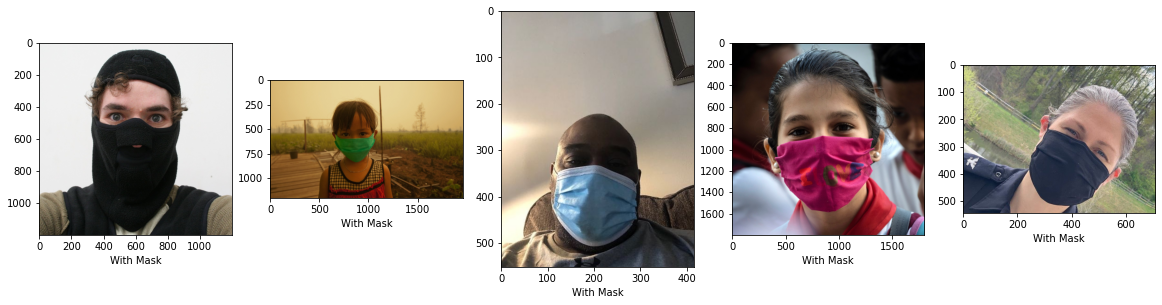

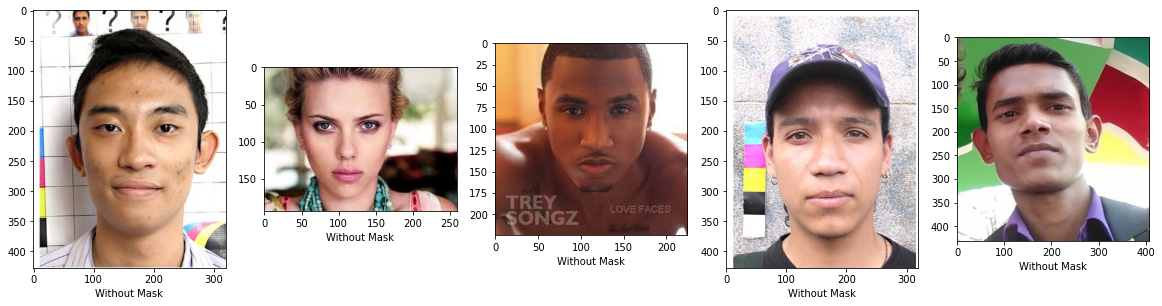

In [ ]:
show_img_samples(with_mask_dirs, 5, 'With Mask')
show_img_samples(without_mask_dirs, 5, 'Without Mask')

In [ ]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

timing_callback = TimingCallback()

In [ ]:
# Call models from Keras Applications
model_dictionary = {'DenseNet121': applications.densenet.DenseNet121}
model_dictionary['DenseNet169'] = applications.densenet.DenseNet169
model_dictionary['MobileNetV2'] = applications.mobilenet_v2.MobileNetV2
model_dictionary['MobileNet'] = applications.mobilenet.MobileNet 
model_dictionary['NASNetMobile'] = applications.nasnet.NASNetMobile
model_dictionary['NASNetLarge'] = applications.nasnet.NASNetLarge
model_dictionary['VGG16'] = applications.vgg16.VGG16
model_dictionary['VGG19'] = applications.vgg19.VGG19
model_dictionary['Xception'] = applications.xception.Xception
model_dictionary['InceptionV3'] = applications.inception_v3.InceptionV3

for key in model_dictionary:
    print(key)

# Evaluation of the Models
model_benchmarks = {'model_name': [], 'num_model_params': [], 'val_loss': [], 'val_accuracy': [], 'avg_train_time': []}

for model_name, model in tqdm(model_dictionary.items()):
    # NASNet Models must have input_shape that fits the model
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
    elif 'NASNetMobile' in model_name:
        input_shape=(224,224,3)
    # The other models have 128x128 as the maximum size.
    else:
        input_shape=(128,128,3)

    # Setting of the base model 
    pre_trained_model = model(
        include_top=False, 
        input_shape=input_shape,
        pooling='avg', 
        classes = 2)
    pre_trained_model.trainable = False
    
    # Transfer learning model setting.
    clf_model = Sequential([
        pre_trained_model,
        #pretrained_base,
        #Flatten(),
        Dense(2, activation='sigmoid')])
    clf_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    # Model training
    history = clf_model.fit(
        train_generator,
        epochs=3, # I have to compare many models, so I set the epoch to 3
        callbacks=[timing_callback],
        validation_data=val_generator)
    
    # Record values for model performance comparison.
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['val_loss'].append(history.history['val_loss'][-1])
    model_benchmarks['val_accuracy'].append(history.history['val_accuracy'][-1])
    model_benchmarks['avg_train_time'].append(sum(timing_callback.logs)/3)

DenseNet121
DenseNet169
MobileNetV2
MobileNet
NASNetMobile
NASNetLarge
VGG16
VGG19
Xception
InceptionV3


  0%|          | 0/10 [00:00<?, ?it/s]

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/3
3/3 [==============================] - 177s 44s/step - loss: 0.6837 - accuracy: 0.6550 - val_loss: 0.6007 - val_accuracy: 0.7222
Epoch 2/3
3/3 [==============================] - 15s 5s/step - loss: 0.5110 - accuracy: 0.8033 - val_loss: 0.4959 - val_accuracy: 0.8529
Epoch 3/3
3/3 [==============================] - 15s 5s/step - loss: 0.4322 - accuracy: 0.8833 - val_loss: 0.4093 - val_accuracy: 0.9118


 10%|█         | 1/10 [04:30<40:38, 270.91s/it]

51888128/51877672 [==============================] - 1s 0us/step
Epoch 1/3
3/3 [==============================] - 34s 9s/step - loss: 0.6863 - accuracy: 0.6333 - val_loss: 0.5582 - val_accuracy: 0.7614
Epoch 2/3
3/3 [==============================] - 15s 5s/step - loss: 0.4936 - accuracy: 0.8017 - val_loss: 0.4094 - val_accuracy: 0.8725
Epoch 3/3
3/3 [==============================] - 15s 5s/step - loss: 0.3370 - accuracy: 0.9283 - val_loss: 0.3205 - val_accuracy: 0.9052


 20%|██        | 2/10 [05:44<20:40, 155.08s/it]

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/3
3/3 [==============================] - 24s 8s/step - loss: 0.7425 - accuracy: 0.5633 - val_loss: 0.6460 - val_accuracy: 0.7386
Epoch 2/3
3/3 [==============================] - 14s 5s/step - loss: 0.5516 - accuracy: 0.8033 - val_loss: 0.5162 - val_accuracy: 0.8725
Epoch 3/3
3/3 [==============================] - 14s 6s/step - loss: 0.4277 - accuracy: 0.9050 - val_loss: 0.4089 - val_accuracy: 0.9118


 30%|███       | 3/10 [06:49<13:15, 113.59s/it]

17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/3
3/3 [==============================] - 21s 9s/step - loss: 0.8734 - accuracy: 0.4733 - val_loss: 0.8699 - val_accuracy: 0.4575
Epoch 2/3
3/3 [==============================] - 14s 5s/step - loss: 0.6875 - accuracy: 0.6517 - val_loss: 0.6959 - val_accuracy: 0.6569
Epoch 3/3
3/3 [==============================] - 14s 5s/step - loss: 0.5484 - accuracy: 0.8067 - val_loss: 0.5593 - val_accuracy: 0.7778


 40%|████      | 4/10 [07:49<09:16, 92.76s/it] 

20004864/19993432 [==============================] - 0s 0us/step
Epoch 1/3
3/3 [==============================] - 38s 9s/step - loss: 0.9435 - accuracy: 0.3850 - val_loss: 0.7777 - val_accuracy: 0.5980
Epoch 2/3
3/3 [==============================] - 14s 6s/step - loss: 0.7274 - accuracy: 0.5900 - val_loss: 0.6456 - val_accuracy: 0.7124
Epoch 3/3
3/3 [==============================] - 14s 6s/step - loss: 0.6068 - accuracy: 0.6933 - val_loss: 0.5581 - val_accuracy: 0.7712


 50%|█████     | 5/10 [09:08<07:17, 87.50s/it]

343621632/343610240 [==============================] - 4s 0us/step
Epoch 1/3
3/3 [==============================] - 52s 14s/step - loss: 0.5862 - accuracy: 0.6633 - val_loss: 0.4683 - val_accuracy: 0.7778
Epoch 2/3
3/3 [==============================] - 19s 8s/step - loss: 0.3325 - accuracy: 0.9317 - val_loss: 0.3006 - val_accuracy: 0.8889
Epoch 3/3
3/3 [==============================] - 18s 8s/step - loss: 0.2236 - accuracy: 0.9550 - val_loss: 0.2255 - val_accuracy: 0.9150


 60%|██████    | 6/10 [10:56<06:18, 94.61s/it]

58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/3
3/3 [==============================] - 56s 13s/step - loss: 0.7206 - accuracy: 0.5000 - val_loss: 0.6806 - val_accuracy: 0.5065
Epoch 2/3
3/3 [==============================] - 14s 5s/step - loss: 0.6894 - accuracy: 0.5133 - val_loss: 0.6568 - val_accuracy: 0.6569
Epoch 3/3
3/3 [==============================] - 15s 7s/step - loss: 0.6580 - accuracy: 0.6683 - val_loss: 0.6441 - val_accuracy: 0.7680


 70%|███████   | 7/10 [12:25<04:38, 92.76s/it]

80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/3
3/3 [==============================] - 20s 7s/step - loss: 0.7046 - accuracy: 0.5183 - val_loss: 0.7128 - val_accuracy: 0.5033
Epoch 2/3
3/3 [==============================] - 15s 7s/step - loss: 0.6815 - accuracy: 0.5700 - val_loss: 0.6938 - val_accuracy: 0.5098
Epoch 3/3
3/3 [==============================] - 15s 5s/step - loss: 0.6666 - accuracy: 0.6500 - val_loss: 0.6824 - val_accuracy: 0.5719


 80%|████████  | 8/10 [13:19<02:40, 80.45s/it]

83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/3
3/3 [==============================] - 27s 8s/step - loss: 0.7265 - accuracy: 0.6367 - val_loss: 0.5392 - val_accuracy: 0.7843
Epoch 2/3
3/3 [==============================] - 15s 7s/step - loss: 0.4808 - accuracy: 0.8100 - val_loss: 0.4446 - val_accuracy: 0.8170
Epoch 3/3
3/3 [==============================] - 15s 5s/step - loss: 0.4102 - accuracy: 0.8500 - val_loss: 0.3664 - val_accuracy: 0.8660


 90%|█████████ | 9/10 [14:28<01:16, 76.81s/it]

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/3
3/3 [==============================] - 29s 8s/step - loss: 0.9992 - accuracy: 0.5133 - val_loss: 0.7996 - val_accuracy: 0.6078
Epoch 2/3
3/3 [==============================] - 14s 5s/step - loss: 0.6501 - accuracy: 0.7050 - val_loss: 0.5689 - val_accuracy: 0.7745
Epoch 3/3
3/3 [==============================] - 14s 5s/step - loss: 0.4239 - accuracy: 0.8783 - val_loss: 0.4291 - val_accuracy: 0.8758


100%|██████████| 10/10 [15:33<00:00, 93.33s/it]


In [ ]:
benchmark_df = pd.DataFrame(model_benchmarks)

benchmark_df.to_csv('pretrained_model_benchmarks.csv')

bm_params_df = benchmark_df.sort_values('num_model_params')
bm_params_df.head(10)

,model_name,num_model_params,val_loss,val_accuracy,avg_train_time
2,MobileNetV2,2257984,0.408902,0.911765,107.184732
3,MobileNet,3228864,0.559255,0.777778,123.424504
4,NASNetMobile,4269716,0.558105,0.771242,145.202071
0,DenseNet121,7037504,0.409348,0.911765,68.682077
1,DenseNet169,12642880,0.320477,0.905229,89.919470
6,VGG16,14714688,0.644076,0.767974,203.037852
7,VGG19,20024384,0.682402,0.571895,219.555129
8,Xception,20861480,0.366447,0.866013,238.410340
9,InceptionV3,21802784,0.429130,0.875817,257.379837
5,NASNetLarge,84916818,0.225501,0.915033,174.903710


In [ ]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

timing_callback = TimingCallback()

In [ ]:
pretrained_base = keras.applications.densenet.DenseNet121(
    include_top=False, 
    input_shape=(128,128,3), 
    pooling='avg',    
    classes = 2) 
pretrained_base.trainable = True

model = Sequential([
    pretrained_base,
    Flatten(),
    Dense(2, activation='sigmoid')])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.fit(train_generator, callbacks=[timing_callback],
          epochs = 200, steps_per_epoch=5, validation_data=val_generator, validation_steps=4,verbose =1) # change epoch

Epoch 1/200
5/5 [==============================] - 20s 2s/step - loss: 0.3313 - accuracy: 0.8062 - val_loss: 7.4369 - val_accuracy: 0.5156
Epoch 2/200
5/5 [==============================] - 5s 1s/step - loss: 0.0882 - accuracy: 0.9688 - val_loss: 2.0300 - val_accuracy: 0.7656
Epoch 3/200
5/5 [==============================] - 5s 1s/step - loss: 0.1586 - accuracy: 0.9563 - val_loss: 23.5214 - val_accuracy: 0.4531
Epoch 4/200
5/5 [==============================] - 5s 1s/step - loss: 0.2816 - accuracy: 0.9438 - val_loss: 49.0470 - val_accuracy: 0.5312
Epoch 5/200
5/5 [==============================] - 5s 1s/step - loss: 0.2311 - accuracy: 0.9312 - val_loss: 1.8611 - val_accuracy: 0.8828
Epoch 6/200
5/5 [==============================] - 5s 1s/step - loss: 0.1275 - accuracy: 0.9563 - val_loss: 8.3296 - val_accuracy: 0.7812
Epoch 7/200
5/5 [==============================] - 5s 1s/step - loss: 0.0543 - accuracy: 0.9803 - val_loss: 12.0511 - val_accuracy: 0.6875
Epoch 8/200
5/5 [=============

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0,
    patience=10, 
    verbose=1,
    mode='min',
    restore_best_weights=True)

In [ ]:
pretrained_base = keras.applications.densenet.DenseNet121(
    include_top=False, 
    input_shape=(128,128,3),
    pooling='avg',  
    classes = 2) 
pretrained_base.trainable = True

model = Sequential([
    pretrained_base,
    Flatten(),
    Dense(2, activation='sigmoid')])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=val_generator)

Epoch 1/100
19/19 [==============================] - 31s 1s/step - loss: 0.2503 - accuracy: 0.9033 - val_loss: 4.3721 - val_accuracy: 0.5359
Epoch 2/100
19/19 [==============================] - 16s 849ms/step - loss: 0.0799 - accuracy: 0.9717 - val_loss: 6.2145 - val_accuracy: 0.5000
Epoch 3/100
19/19 [==============================] - 16s 851ms/step - loss: 0.0501 - accuracy: 0.9867 - val_loss: 2.5539 - val_accuracy: 0.8039
Epoch 4/100
19/19 [==============================] - 16s 845ms/step - loss: 0.0421 - accuracy: 0.9867 - val_loss: 0.6965 - val_accuracy: 0.8922
Epoch 5/100
19/19 [==============================] - 16s 848ms/step - loss: 0.0523 - accuracy: 0.9900 - val_loss: 4.6111 - val_accuracy: 0.5980
Epoch 6/100
19/19 [==============================] - 16s 844ms/step - loss: 0.0355 - accuracy: 0.9900 - val_loss: 0.4968 - val_accuracy: 0.8824
Epoch 7/100
19/19 [==============================] - 16s 841ms/step - loss: 0.0580 - accuracy: 0.9783 - val_loss: 1.2797 - val_accuracy: 0.

Model Performance Check

Minimum validation loss: 0.08765026926994324
Maximum validation accuracy: 0.9708737730979919


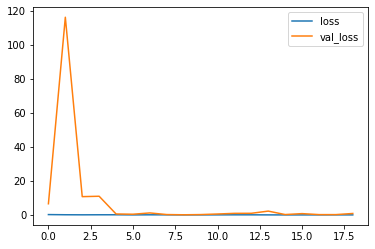

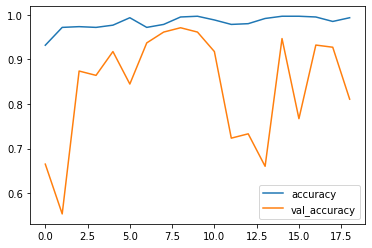

In [ ]:
history_df = pd.DataFrame(history.history)
history_df
history_df.loc[:, ['loss', 'val_loss']].plot();
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(history_df['val_accuracy'].max()))

In [ ]:
model.evaluate(test_generator, verbose = 1)

4/4 [==============================] - 3s 689ms/step - loss: 0.0063 - accuracy: 1.0000


[0.006272667553275824, 1.0]

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
from matplotlib import pyplot as plt
from google.colab import files
from IPython import display

np.set_printoptions(precision=  1000)

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (128, 128, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

dummy_path = '/content/gdrive/My Drive/New Masks Dataset/Member_Picture/Min_mask.jpg'
dummy_path2 = '/content/gdrive/My Drive/New Masks Dataset/Member_Picture/Min_nonMask.jpg'
dummy_path3 = '/content/gdrive/My Drive/New Masks Dataset/Member_Picture/Anas_mask.jpeg'
dummy_path4 = '/content/gdrive/My Drive/New Masks Dataset/Member_Picture/Anas_nonMask.jpeg'

image = load(dummy_path)
image2 = load(dummy_path2)
image3 = load(dummy_path3)
image4 = load(dummy_path4)

print("       Mask   |  Non Mask ")
print("______________________________")

print("Minsoo ______________")
print(model.predict(image))
print(model.predict(image2))

print("Anas ______________")
print(model.predict(image3))
print(model.predict(image4))


       Mask   |  Non Mask 
______________________________
Minsoo ______________
[[0.9886514   0.016701743]]
[[1.3173648e-05 9.9998891e-01]]
Anas ______________
[[0.979313    0.028554162]]
[[9.320777e-12 1.000000e+00]]


Testing some other stuff

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.utils import np_utils

model = Sequential()

model.add(Conv2D(2,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(3,(2,2),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(8,activation='relu'))
model.add(Dense(3,activation='softmax'))


In [ ]:
#model.save('/content/drive/My Drive/MaskedOrNo')
model.save_weights("my_model_weights.h5")

In [ ]:
#A callback you can use                             
filepath = '/tmp/weights.{epoch:02d}-{val_loss:.2f}.hdf5' #saves the best weights

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath, 
                                              monitor = 'val_loss', 
                                              verbose = 1, 
                                              save_best_only = True, 
                                              save_weights_only = True, 
                                              mode = 'avg')

NameError: ignored